# In this jupyter notebook, I perform arrithmetic addition using quantum circuit model.   


In [2]:
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer
from qiskit.tools.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor, backend_monitor, backend_overview
from qiskit import IBMQ

In [342]:
import matplotlib.pyplot as plt

In [3]:
# The IBMQ token was saved earlier in the local machine.
IBMQ.load_accounts()

In [3]:
accountinfo=IBMQ.stored_accounts()
accountinfo[0]['token']
#IBMQ.enable_account(accountinfo[0]['token'])

/anaconda3/envs/qiskitenv/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqprovider.py:251: UserWarning: Credentials are already in use.
  warnings.warn('Credentials are already in use.')


In [4]:
IBMQ.backends()

[<IBMQBackend('ibmqx4') from IBMQ()>,
 <IBMQBackend('ibmqx2') from IBMQ()>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ()>,
 <IBMQBackend('ibmq_qasm_simulator') from IBMQ()>]

In [83]:
 # recall how classical addition of two integers.
def classical_add(x,y):
    while (y!=0):
        carry=(x&y)
        x=x^y
        y=carry<<1
    return x

In [5]:
# this circuit model calculates single bit addition
def fulladd(int1=1, int2=1, cin=1):
    q=QuantumRegister(4)
    c=ClassicalRegister(2)
    circuit=QuantumCircuit(q,c)
    # prepare the init state
    if int1: circuit.x(q[0])
    if int2: circuit.x(q[1])
    if cin: circuit.x(q[2])
    
    # apply gate
    circuit.ccx(q[0],q[1],q[3])
    circuit.cx(q[0],q[1])
    circuit.ccx(q[1],q[2],q[3])
    circuit.cx(q[1],q[2])
    circuit.cx(q[0],q[1])
    # measure
    circuit.measure(q[2],c[0])
    circuit.measure(q[3],c[1])
    return circuit

In [6]:
cir=fulladd(1,0,1)

In [7]:
cir.draw()

{'10': 1024}


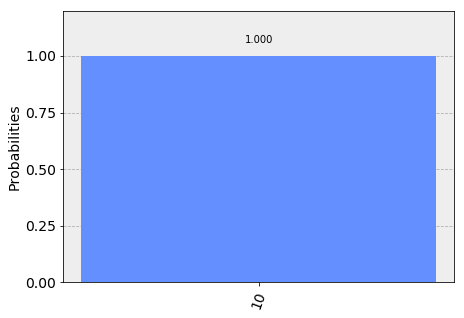

In [8]:
# compute on simulator
job = execute(cir, backend = Aer.get_backend('qasm_simulator'), shots=1024)
result = job.result()
print(result.get_counts())
plot_histogram(result.get_counts())


In [10]:
# Now let's compute on real quantum bit and see how the results different from the previous. 
job_q = execute(cir, backend=IBMQ.get_backend('ibmqx4'), shots=1024)


In [101]:
job_monitor(job_q)

HTML(value="<p style='font-size:16px;'>Job Status: job has successfully run </p>")

In [102]:
result_q = job_q.result()
result_q.get_counts()

{'01': 226, '10': 397, '11': 86, '00': 315}

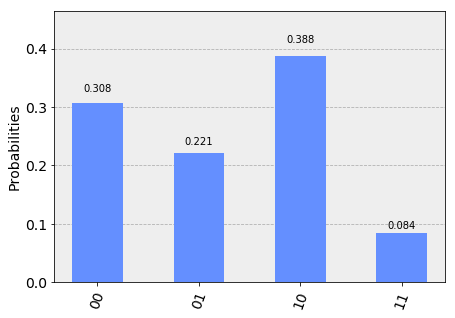

In [103]:
plot_histogram(result_q.get_counts())

## Remarks on the different results on the simulator and real qubit    
In this example, the real qubits are entangled and not giving the expected result, i.e. $(11)_2 = (3)_{10}$, beuase the each bit is not isolated. To further understand the source of error, the relaxation and decoherence time can be studied with the noise model. More work can be done to understand the correction and control of error.

Despite the inaccuracy in qubits, let's stay with the simulator and generalize the single bit addition to multiple bits. 

In [322]:
print('Enter the two integers to add, must < 255 ')
input1 = input()
input2=input()
print('The two ints are {} and {} '.format(input1, input2))
input1=int(input1)
input2=int(input2)


Enter the two integers to add, must < 255 
2
3
The two ints are 2 and 3 


In [323]:
# define qunatum register that stores int1, int2 and carry
bitstring1=bin(input1)[2:]
bitstring2=bin(input2)[2:]
maxbitlen=max(len(bitstring1), len(bitstring2))
int1=QuantumRegister(maxbitlen)
int2=QuantumRegister(maxbitlen)
carry=QuantumRegister(maxbitlen+1)
s=QuantumRegister(maxbitlen+1)
c_carry=ClassicalRegister(maxbitlen+1)
c_s=ClassicalRegister(maxbitlen+1)
cir=QuantumCircuit(int1, int2, carry,c_carry,s,c_s)

In [324]:
#assign values to int1, int2 qubit
for i in range(len(bitstring1)):
    if int(bitstring1[::-1][i])==1:
        cir.x(int1[i])

for i in range(len(bitstring2)):
    if int(bitstring2[::-1][i])==1:
        cir.x(int2[i])
        
# calculate carry
for i in range(maxbitlen):
        cir.ccx(int1[i],int2[i],s[i+1])
        
# calculate sum
for i in range(maxbitlen):
    cir.cx(int1[i],int2[i])
    
# calculate sum + carry
for i in range(maxbitlen):
    cir.ccx(int2[i],s[i],carry[i+1])
    cir.cx(int2[i],s[i])

#measurement
cir.measure(s,c_s)   
cir.measure(carry,c_carry)


Now, we have built the quantum circuit for computing the addition of two integers. We will run the computation on simulator and then on the real qubits 'ibmq_16_melbourne'.   
We will use two following helper functions to help use get the final result in decimal.

In [332]:
def get_most_prob_bitstring(result_dict):
    print(result_dict)
    bitstr=(max(result_dict, key = lambda x: result_dict[x]).replace(" ", ""))
    #print("Highest probability outcome: {}".format(int(max(result_dict, key = lambda x: result_dict[x]).replace(" ", ""), 2)))
    return bitstr
    

In [333]:
def bin2decimal(bit):
    l=len(bit)
    s=bit[:l//2]
    carry=bit[l//2:]
    ans=0
    for i in range(l//2):
        ans+=int(s[::-1][i])*2**i
        ans+=int(carry[::-1][i])*2**i
    return ans

In [339]:
job = execute(cir, backend = Aer.get_backend('qasm_simulator'), shots=16)

In [340]:
job_monitor(job)

HTML(value="<p style='font-size:16px;'>Job Status: job has successfully run </p>")

In [343]:
result=job.result()
bit=get_most_prob_bitstring(result.get_counts())
ans=bin2decimal(bit)
print('Quantum computation of addition: {} + {} = {}'.format(input1, input2, ans))

{'101 000': 16}
Quantum computation of addition: 2 + 3 = 5


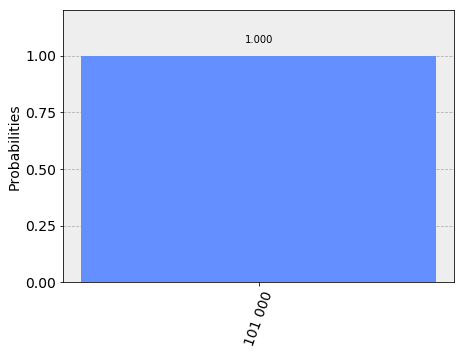

In [345]:
plot_histogram(result.get_counts())

In [329]:

job_q = execute(cir, backend=IBMQ.get_backend('ibmq_16_melbourne'), shots=1024)

In [330]:
job_monitor(job_q)

HTML(value="<p style='font-size:16px;'>Job Status: job is being initialized </p>")

In [335]:
result_q = job_q.result()

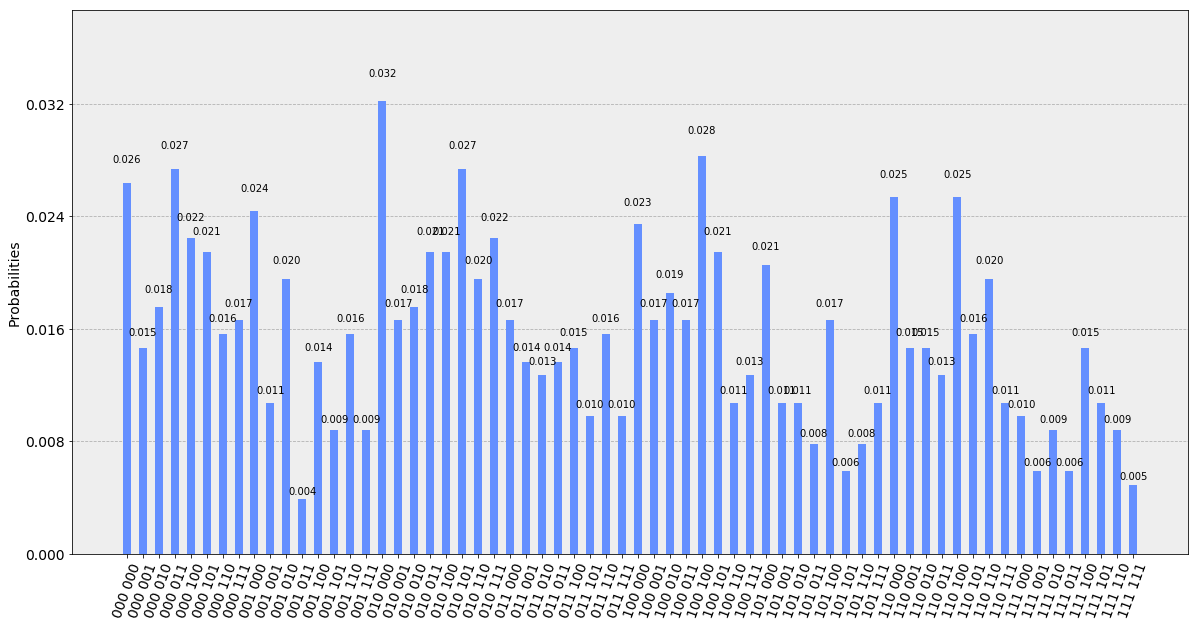

In [347]:

plot_histogram(result_q.get_counts(), figsize=(20,10))

In [338]:
bit=get_most_prob_bitstring(result_q.get_counts())
ans=bin2decimal(bit)
print('Quantum computation of addition: {} + {} = {}'.format(input1, input2, ans))

{'110 110': 20, '001 110': 16, '000 010': 18, '110 100': 26, '010 000': 33, '101 111': 11, '010 111': 23, '010 001': 17, '011 000': 17, '101 011': 8, '101 110': 8, '101 001': 11, '000 001': 15, '001 100': 14, '000 011': 28, '010 110': 20, '000 111': 17, '011 100': 15, '111 011': 6, '100 111': 13, '100 000': 24, '111 101': 11, '110 101': 16, '001 111': 9, '100 010': 19, '011 111': 10, '101 101': 6, '100 101': 22, '111 000': 10, '000 100': 23, '110 001': 15, '100 011': 17, '110 000': 26, '101 010': 11, '010 100': 22, '010 011': 22, '100 110': 11, '011 011': 14, '011 101': 10, '010 101': 28, '110 010': 15, '100 100': 29, '011 001': 14, '000 000': 27, '000 110': 16, '111 100': 15, '001 001': 11, '101 000': 21, '100 001': 17, '001 011': 4, '111 010': 9, '001 000': 25, '001 010': 20, '011 010': 13, '010 010': 18, '111 001': 6, '000 101': 22, '101 100': 17, '111 110': 9, '110 011': 13, '110 111': 11, '011 110': 16, '001 101': 9, '111 111': 5}
Quantum computation of addition: 2 + 3 = 2


## Remarks:   
Actually, the most efficient quantum adder would be to utilize the quantum Fourier transform in which the addition is performed in the phase. I will show the algorithm for arithmetic after introducing the quantum Fourier transform. This is still a nice warm-up project for getting familiar with quantum arithmetic.   
The control and reduction of error in real qubits will be discussed in the latter parts.